# Spotify.com Chart Data Research
### Web Scraping, Visualization, Tabulation, and Bootstrap Hypothesis Testing

In late 2019, I wrote a suite of Python scripts to make data inquiries into public Spotify streaming data.

These scripts were some of the first things I ever coded, and I made them to demonstrate my Python competency in applications to graduate school. In that respect, they were successful: I'm currently attending UCLA Anderson to get my Master's in Business Analytics. Of course, I would have approached some of the programming differently had I made them today. Nevertheless, I'm still proud of what they do, and as you'll see below, I used them to prove a hypothesis about Spotify streaming that I still find quite interesting.

## Web Scraping

To fuel my data inquiries, I first put together a simple script that gathered public data from Spotify.com. I started with a (now-deleted) scraper built by Reddit user 'mbizkid' originally found [here](https://www.reddit.com/r/learnpython/comments/becnzn/i_built_a_web_scraper_for_spotify_top_200_daily/), which tracks Spotify's global top-200 songs chart, capturing the top-played songs in the world on any given day.

The script I ended with saves daily streaming data into a CSV, and slightly more robust data into multiple SQL tables. 

I've hashed out the sections concerning SQL functionality for the purposes of this document.

In [ ]:
# Create Spotify.com chart scraper
import requests
from bs4 import BeautifulSoup
from datetime import date, timedelta
from time import time
from time import sleep
from random import randint
import pandas as pd
import csv

'''
# Import SQLAlchemy and create a supplementary SQL database in the working directory
from sqlalchemy import Column, ForeignKey, Integer, String, MetaData
from sqlalchemy import create_engine
engine = create_engine('sqlite:///spotifytrack.db', echo=None) 
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy.orm import relationship

# Define schema for SQL table Artist
class Artist(Base):
    __tablename__ = 'artists'
    
    id = Column(Integer, primary_key = True)
    name = Column(String)

# Create the SQL table Song: tracks performance of songs appearing in Top 200
class Song(Base):
    __tablename__ = 'songs'
    id = Column(Integer, primary_key = True)
    songname = Column(String)
    daily_streams = Column(Integer)
    peak_streams = Column(Integer)
    cum_streams = Column(Integer)
    daily_chart = Column(Integer)
    highest_chart = Column(Integer)
    peak_date = Column(String)
    art_id = Column(Integer, ForeignKey('artists.id'))
    artist = relationship("Artist", back_populates = "songs")

# Set relationship between SQL Tables
Artist.songs = relationship("Song", order_by = Song.id, back_populates = "artist")
Base.metadata.create_all(engine)
'''

# Check for master CSV, and create CSV with appropriate heading if nonexistent
with open("MasterSpotifyData.csv", mode="a", newline="") as f:
    data_handler = csv.writer(f, delimiter=",")
    row_count = 0
    for row in open("MasterSpotifyData.csv"):
        row_count += 1
    
    if row_count == 0:
        data_handler.writerow(["SongTitle", "Artist", "DailyStreams", "ChartRank", "Date", "DayOfWeek"])  

# Sets base Spotify.com URL
base_url = 'https://spotifycharts.com/regional/global/daily/'

# Reads existing data to find date range
old = pd.read_csv("MasterSpotifyData.csv")
old_date = old.Date.max()
row_count = 0
for row in old:
    row_count += 1
converted_date = date(2020, 1, 1)
if row_count <= 1:
    split_date = old_date.split('-')
    converted_date = date(int(split_date[0]), int(split_date[1]), int(split_date[2]))

# Sets scraping date range
start = converted_date
end = date.today()
iter = timedelta(days=1)
mydate = start

# Creates empty array to hold all potentially scraped data
all_rows = []

while mydate < end:

    if(mydate > end):
        break

    # Connects to Spotify.com charts at specific page for each date 
    data = requests.get(base_url + mydate.strftime('%Y-%m-%d'))
    mydate += iter

    # Suspends script before each next day to temporarily free up processing power
    sleep(randint(1,3))

    # Creates BeautifulSoup HTML parser
    soup = BeautifulSoup(data.text, 'html.parser')

    # Establishes where data we are interested starts and ends
    chart = soup.find('table', {'class': 'chart-table'})
    tbody = chart.find('tbody')

    # Scrapes data!
    for tr in tbody.find_all('tr'):

        # Scrapes each chart position
        rank_text = tr.find('td', {'class': 'chart-table-position'}).text

        # Scrapes artist name, removes unnecessary language
        artist_text = tr.find('td', {'class': 'chart-table-track'}).find('span').text
        artist_text = artist_text.replace('by ','').strip()

        # Scrapes song title
        title_text = tr.find('td', {'class': 'chart-table-track'}).find('strong').text

        # Scrapes daily streams
        streams_text = tr.find('td', {'class': 'chart-table-streams'}).text

        # Corrects date
        date = (mydate - iter)
        
        # Converts stream data to usable type
        streams = int(streams_text.replace(",",""))
        
       '''
        # Adds artist-specific data to Artist SQL table
        from sqlalchemy.orm import sessionmaker
        Session = sessionmaker(bind = engine)
        session = Session()
        result = session.query(Artist).all()
        charted_artists = [row.name for row in result]
        if artist_text not in charted_artists:
            a1 = Artist(name = artist_text)
            session.add(a1)
            session.commit()
        
        # Adds song-specific data to Song SQL table
        streams = int(streams_text.replace(",",""))
        result = session.query(Song).all()
        charted_songs = [item.songname for item in result]
        
        if title_text in charted_songs:
        
            # Updates chart placement and streaming data for songs already in Song table
            s = session.query(Song).filter_by(songname=title_text)
            for row in s:
                if int(rank_text) < row.highest_chart:
                    x = session.query(Song).get(row.id)
                    x.highest_chart = int(rank_text)
                    x.peak_date = date.strftime('%Y-%m-%d')
                    session.commit()
                if streams > row.peak_streams:
                    x = session.query(Song).get(row.id)
                    x.peak_streams = streams
                    session.commit()
                row.daily_chart = int(rank_text)
                row.cum_streams = row.cum_streams + streams
                session.commit() 
                
        else:
            s = session.query(Artist).filter_by(name=artist_text)
            for row in s:
                s1 = Song(songname = title_text, daily_streams = streams, peak_streams = streams, cum_streams = streams, \
                daily_chart = int(rank_text), highest_chart = int(rank_text), peak_date = date.strftime('%Y-%m-%d'), art_id = row.id)
            session.add(s1)
            session.commit()
            
        '''

        # Collects all scraped data to one line of array
        all_rows.append([title_text, artist_text, streams, int(rank_text), date.strftime('%Y-%m-%d'), date.strftime('%A')])
        
    # Informs user in output that a date has been scraped
    date_text = mydate.strftime('%Y-%m-%d')
    print(f"{date_text} chart data scraped")

# Saves/appends all scraped data to master CSV
with open("MasterSpotifyData.csv", "a") as f:
    data_handler = csv.writer(f, delimiter=",")
    data_handler.writerows(all_rows)

For purposes of illustration, below is the head of the MasterSpotifyData CSV, along with a screenshot of the kind of data that the SQL functionality tracked.

In [2]:
data = pd.read_csv("MasterSpotifyData.csv")
data.head()

,SongTitle,Artist,DailyStreams,ChartRank,Date,DayOfWeek
0,Dance Monkey,Tones And I,6155025,1,2020-01-01,Wednesday
1,ROXANNE,Arizona Zervas,4133489,2,2020-01-01,Wednesday
2,Tusa,"KAROL G, Nicki Minaj",4017964,3,2020-01-01,Wednesday
3,Circles,Post Malone,3283180,4,2020-01-01,Wednesday
4,Memories,Maroon 5,3127585,5,2020-01-01,Wednesday


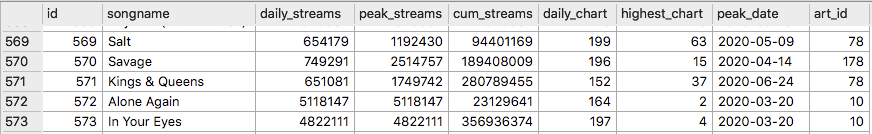

## Basic User-Guided Tabulation & Visualization

Using the scraped data, I coded a script that provided 5 options for basic top-200 listening trend analysis. Their functions are listed below:

1) Plots a basic graph showing a song's global Spotify streaming performance over the year of 2020

2) Same as above, but for two songs instead of one, for the purpose of visual comparison

3) Takes a range of dates and outputs a list of most "dominant" songs on Spotify in that date range, as computed by chart rank

4) Takes a range of dates and outputs a list of the highest-streaming songs on Spotify in that date range

5) Takes a range of dates and outputs the 5 songs most consistently rising and falling in chart rank in that date range

Below, I have provided screenshots showing use of the 5 options.

In [ ]:
from tkcalendar import Calendar, DateEntry
import tkinter as tk
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import sys
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
import datetime
from dateutil.parser import parse

# Makes adjustements to matplotlib parameters
register_matplotlib_converters()
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
mpl.use('tkagg')

# Clears plot in case of repeat runs
plt.clf()

# Sets default dates
date_start = datetime.datetime
date_end = datetime.datetime

# Creates calendar for user to select starting date for analysis
def startcalendar():

    def print_sel():
        global date_start 
        date_start = np.datetime64(cal.selection_get())
        print("Start date: ",date_start)
        top.destroy()

    top = tk.Toplevel(root)
    mindate = pd.Timestamp(year=2018, month=11, day=23)
    maxdate = pd.Timestamp(year=2020, month=10, day=1)

    cal = Calendar(top, font="Arial 14", selectmode='day', foreground='black', locale='en_US',
                   mindate=mindate, maxdate=maxdate, disabledforeground='red', showweeknumbers = False,
                   showothermonthdays = False,
                   cursor="hand1", year=2020, month=1, day=1, date_pattern='y-mm-dd')
    cal.pack(fill="both", expand=True)
    tk.Button(top, text="ok", command=print_sel).pack()

# Creates calendar for user to select ending date for analysis
def endcalendar():
    
    import datetime
    from dateutil.parser import parse

    def print_sel():
        global date_end 
        date_end = np.datetime64(cal.selection_get())
        print("End date: ",date_end)
        top.destroy()

    top = tk.Toplevel(root)
    mindate = pd.Timestamp(year=2020, month=1, day=1)
    maxdate = pd.Timestamp(year=2020, month=10, day=1)

    cal = Calendar(top, font="Arial 14", selectmode='day', foreground='black', locale='en_US',
                   mindate=mindate, maxdate=maxdate, disabledforeground='red', showweeknumbers = False,
                   showothermonthdays = False,
                   cursor="hand1", year=2020, month=1, day=1, date_pattern='y-mm-dd')
    
    cal.pack(fill="both", expand=True)
    tk.Button(top, text="ok", command=print_sel).pack()    

# Closes calendar
def closecalendar():
    root.quit()

# Other calendar defaults
days = mdates.DayLocator()  
months = mdates.MonthLocator() 
count = 1


while count == 1:
    
    choice = int(input(
        "\nChoose an option from the following: \n"
        "Type 1 to graph Spotify global streaming performance for a specific song in 2020 \n"
        "Type 2 to compare two songs' 2020 global Spotify streaming graphs \n"
        "Type 3 to check the highest-charting songs on average for a particular time period \n"
        "Type 4 to check the top-streaming songs on Spotify for a particular time period \n"
        "Type 5 to check the songs most consistently rising and falling in chart rank for a particular time period \n\n"
        "Type -1 to quit.\n\n"))

    # Clears plot if user chooses to do more than one analysis
    plt.clf()

    # Quits
    if choice == -1:
        count = 0

    # Choice 1: Graphs streaming performance for user-specified song in Spotify's global top 200 songs
    if choice == 1:
        while True:
            try:
                df = pd.read_csv('MasterSpotifyData.csv')
                songname = input("What song would you like to see the 2020 global stream performance graph of? \n")
                df = df[df.SongTitle == str(songname)]
                
                if len(df.index) == 0:
                    raise Exception("Data is empty")
                if len(df.index) == 1:
                    raise Exception("Not enough data!")
                df['Date'] = pd.to_datetime(df['Date'])
            
                fig, ax = plt.subplots()
                ax.plot(df.Date, df.DailyStreams)
                locator = mdates.DayLocator(interval=1)
                ax.xaxis.set_major_locator(months)
                ax.xaxis.set_minor_locator(locator)
                
                datefmt = mdates.DateFormatter("%d-%b-%Y")
                fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
                plt.gca().format_coord = fmt
                
                plt.xlabel("Date")
                plt.ylabel("Daily streams")
                plt.title(songname + " 2020 global Spotify streams")
                fig.autofmt_xdate()
                plt.show()
                break
                
            except Exception:
                print("that song isn't in our database... try a more popular one (or spell the song right!)")
                continue

    # Choice 2: Graphs streaming performance for two user-specified songs in Spotify's global top 200 songs
    elif choice == 2:
        while True:
            try:
                dtypes = {'SongTitle': 'str', 'Artist': 'str', 'DailyStreams': 'int', \
                          'ChartRank': 'int', 'Date': 'str', 'DayOfWeek': 'str'}
                parse_dates = ['Date', 'DayOfWeek']
                df = pd.read_csv('MasterSpotifyData.csv', dtype=dtypes, parse_dates=parse_dates)
                songname1 = input("What's the first song you would like to compare?\n")
                df1 = df[df.SongTitle == str(songname1)]
                if len(df1.index) == 0:
                    raise Exception("Data is empty")
                if len(df1.index) == 1:
                    raise Exception("Not enough data!")
                songname2 = input("What's the second song you would like to compare?\n")
                df2 = df[df.SongTitle == str(songname2)]
                if len(df2.index) == 0:
                    raise Exception("Data is empty")
                if len(df2.index) == 1:
                    raise Exception("Not enough data!")
       
                fig, ax = plt.subplots()
                ax.plot(df1.Date, df1.DailyStreams, label=songname1)
                ax.plot(df2.Date, df2.DailyStreams, label=songname2)
                locator = mdates.DayLocator(interval=1)
                ax.xaxis.set_major_locator(months)
                ax.xaxis.set_minor_locator(locator)
                
                datefmt = mdates.DateFormatter("%d-%b-%Y")
                fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
                plt.gca().format_coord = fmt
                
                plt.xlabel("Date")
                plt.ylabel("Daily streams")
                plt.legend(loc="upper right")
                plt.title(songname1 + " & " + songname2 + " compared 2020 global Spotify streams")
                fig.autofmt_xdate()
                plt.show()
                break
                
            except Exception:
                print("that song isn't in our database... try a more popular one (or spell the song right!)")
                continue

    # Choice 3: Tabulates songs with highest average chart rank during user-specified time period
    elif choice == 3:
        dtypes = {'SongTitle': 'str', 'Artist': 'str', 'DailyStreams': 'int', \
                  'ChartRank': 'int', 'Date': 'str', 'DayOfWeek': 'str'}
        parse_dates = ['Date', 'DayOfWeek']
        df = pd.read_csv('MasterSpotifyData.csv', dtype=dtypes, parse_dates=parse_dates)

        # Generates calendar for the user to select a date range. Same construction in analysis choices 4 and 5.
        print("\nPick a start and end date")
        root = tk.Tk()
        tk.Button(root, text='Start date', command=startcalendar).pack(padx=10, pady=10)
        tk.Button(root, text='End date', command=endcalendar).pack(padx=10, pady=10)
        tk.Button(root, text='Click when done', command=root.quit).pack(padx=10, pady=10)
        root.mainloop()
        root.update()
        if date_start > date_end:
            raise Exception("your end date is not before the start date")
        SDRdf = df[['SongTitle','ChartRank','Date']]
        SDRdf_timeperiod = SDRdf.loc[(SDRdf['Date'] <= date_end) & (SDRdf['Date'] >= date_start)] 
        print("\nThe songs with the highest average global chart rank on Spotify for that time period were: \n")
        print(SDRdf_timeperiod.groupby('SongTitle')['ChartRank'].mean().sort_values().head(10))

    # Choice 4: Tabulates songs with highest stream counts in global top 200 songs during user-specified time period
    elif choice == 4:
        dtypes = {'SongTitle': 'str', 'Artist': 'str', 'DailyStreams': 'int', \
                  'ChartRank': 'int', 'Date': 'str', 'DayOfWeek': 'str'}
        parse_dates = [4, 5]
        df = pd.read_csv('MasterSpotifyData.csv', dtype=dtypes, parse_dates=parse_dates)
        print("\nPick a start and end date")
        root = tk.Tk()
        tk.Button(root, text='Start date', command=startcalendar).pack(padx=10, pady=10)
        tk.Button(root, text='End date', command=endcalendar).pack(padx=10, pady=10)
        tk.Button(root, text='Click when done', command=closecalendar).pack(padx=10, pady=10)
        root.mainloop()
        if date_start > date_end:
            raise Exception("your end date is not before the start date")
        date_start_str = str(date_start)
        date_end_str = str(date_end)
        SSRdf = df[['SongTitle','DailyStreams','Date']]
        SSRdf_selection = SSRdf.loc[(SSRdf['Date'] <= date_end) & (SSRdf['Date'] >= date_start)] 
        print("\nThe most-streamed songs on Spotify for the time period between " + date_start_str + " and " + date_end_str + " were: \n")
        print(SSRdf_selection.groupby('SongTitle')['DailyStreams'].sum().sort_values(ascending=False).head(10))

    # Choice 5: Takes user dates and runs a time-series regression on streams for every song appearing on Spotify's chart.
    #  Outputs the songs on the chart with highest and lowest slopes, equating to the most consistently rising 
    #  and consistently falling songs in that time period. Very computationally expensive!
    elif choice == 5:
        dtypes = {'SongTitle': 'str', 'Artist': 'str', 'DailyStreams': 'int', \
                  'ChartRank': 'int', 'Date': 'str', 'DayOfWeek': 'str'}
        parse_dates = ['Date', 'DayOfWeek']
        df = pd.read_csv('MasterSpotifyData.csv', dtype=dtypes, parse_dates=parse_dates)
        print("\nPick a start and end date")
        root = tk.Tk()
        tk.Button(root, text='Start date', command=startcalendar).pack(padx=10, pady=10)
        tk.Button(root, text='End date', command=endcalendar).pack(padx=10, pady=10)
        tk.Button(root, text='Click when done', command=closecalendar).pack(padx=10, pady=10)
        root.mainloop()
        if date_start > date_end:
            raise Exception("your end date is not before the start date")
        SSRdf = df[['SongTitle','DailyStreams','Date']]
        SSR = SSRdf.loc[(SSRdf['Date'] <= date_end) & (SSRdf['Date'] >= date_start)] 
        SSR['SimpDate'] = 0
        date_start = date_start.astype(datetime.date)
        for i, date in enumerate(SSR.loc[:,'Date']):
            z = SSR[['Date']].iloc[i][0].date()
            delta = z - date_start
            simp = delta.days
            SSR.iloc[i, 3] = simp

        streamslope = np.empty(len(SSR.loc[SSR['Date'] == date_end]['SongTitle']))
        streamintercept = np.empty(len(SSR.loc[SSR['Date'] == date_end]['SongTitle']))
        streamnames = ["" for x in range(len(SSR.loc[SSR['Date'] == date_end]['SongTitle']))]

        for i, song in enumerate(SSR.loc[SSR['Date'] == date_end]['SongTitle']):
            a, b = np.polyfit(SSR.loc[SSR.SongTitle == song, 'SimpDate'], SSR.loc[SSR.SongTitle == song, 'DailyStreams'], 1)
            streamslope[i] = a
            streamintercept[i] = b
            streamnames[i] = song
        d = {'SongTitle':streamnames, 'StreamSlope':streamslope, 'StreamIntercept':streamintercept}
        StreamFits = pd.DataFrame(data=d)
        print("\nThe 5 most consistently rising and falling in chart rank on Spotify for the time period selected were: \n")
        print(StreamFits.groupby('StreamSlope')['SongTitle'].head(10))

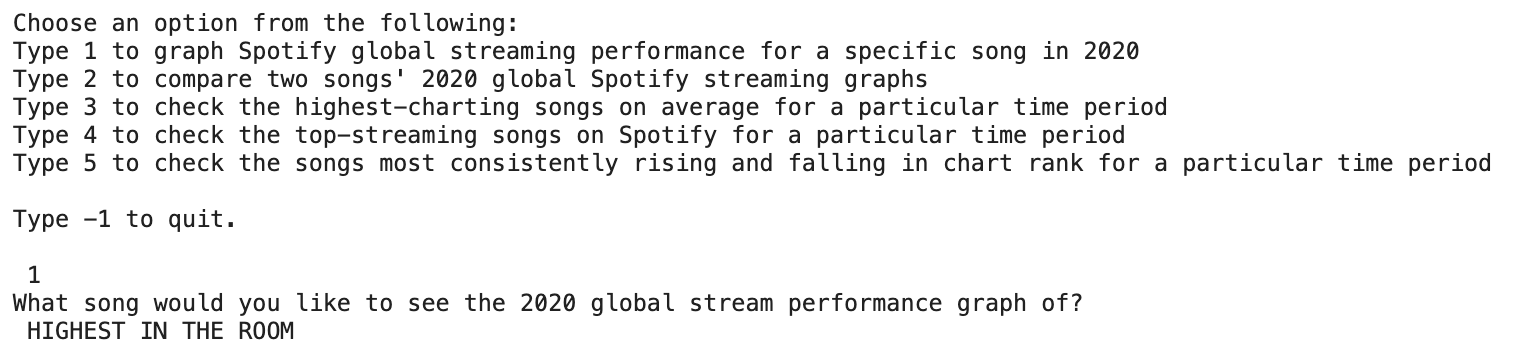
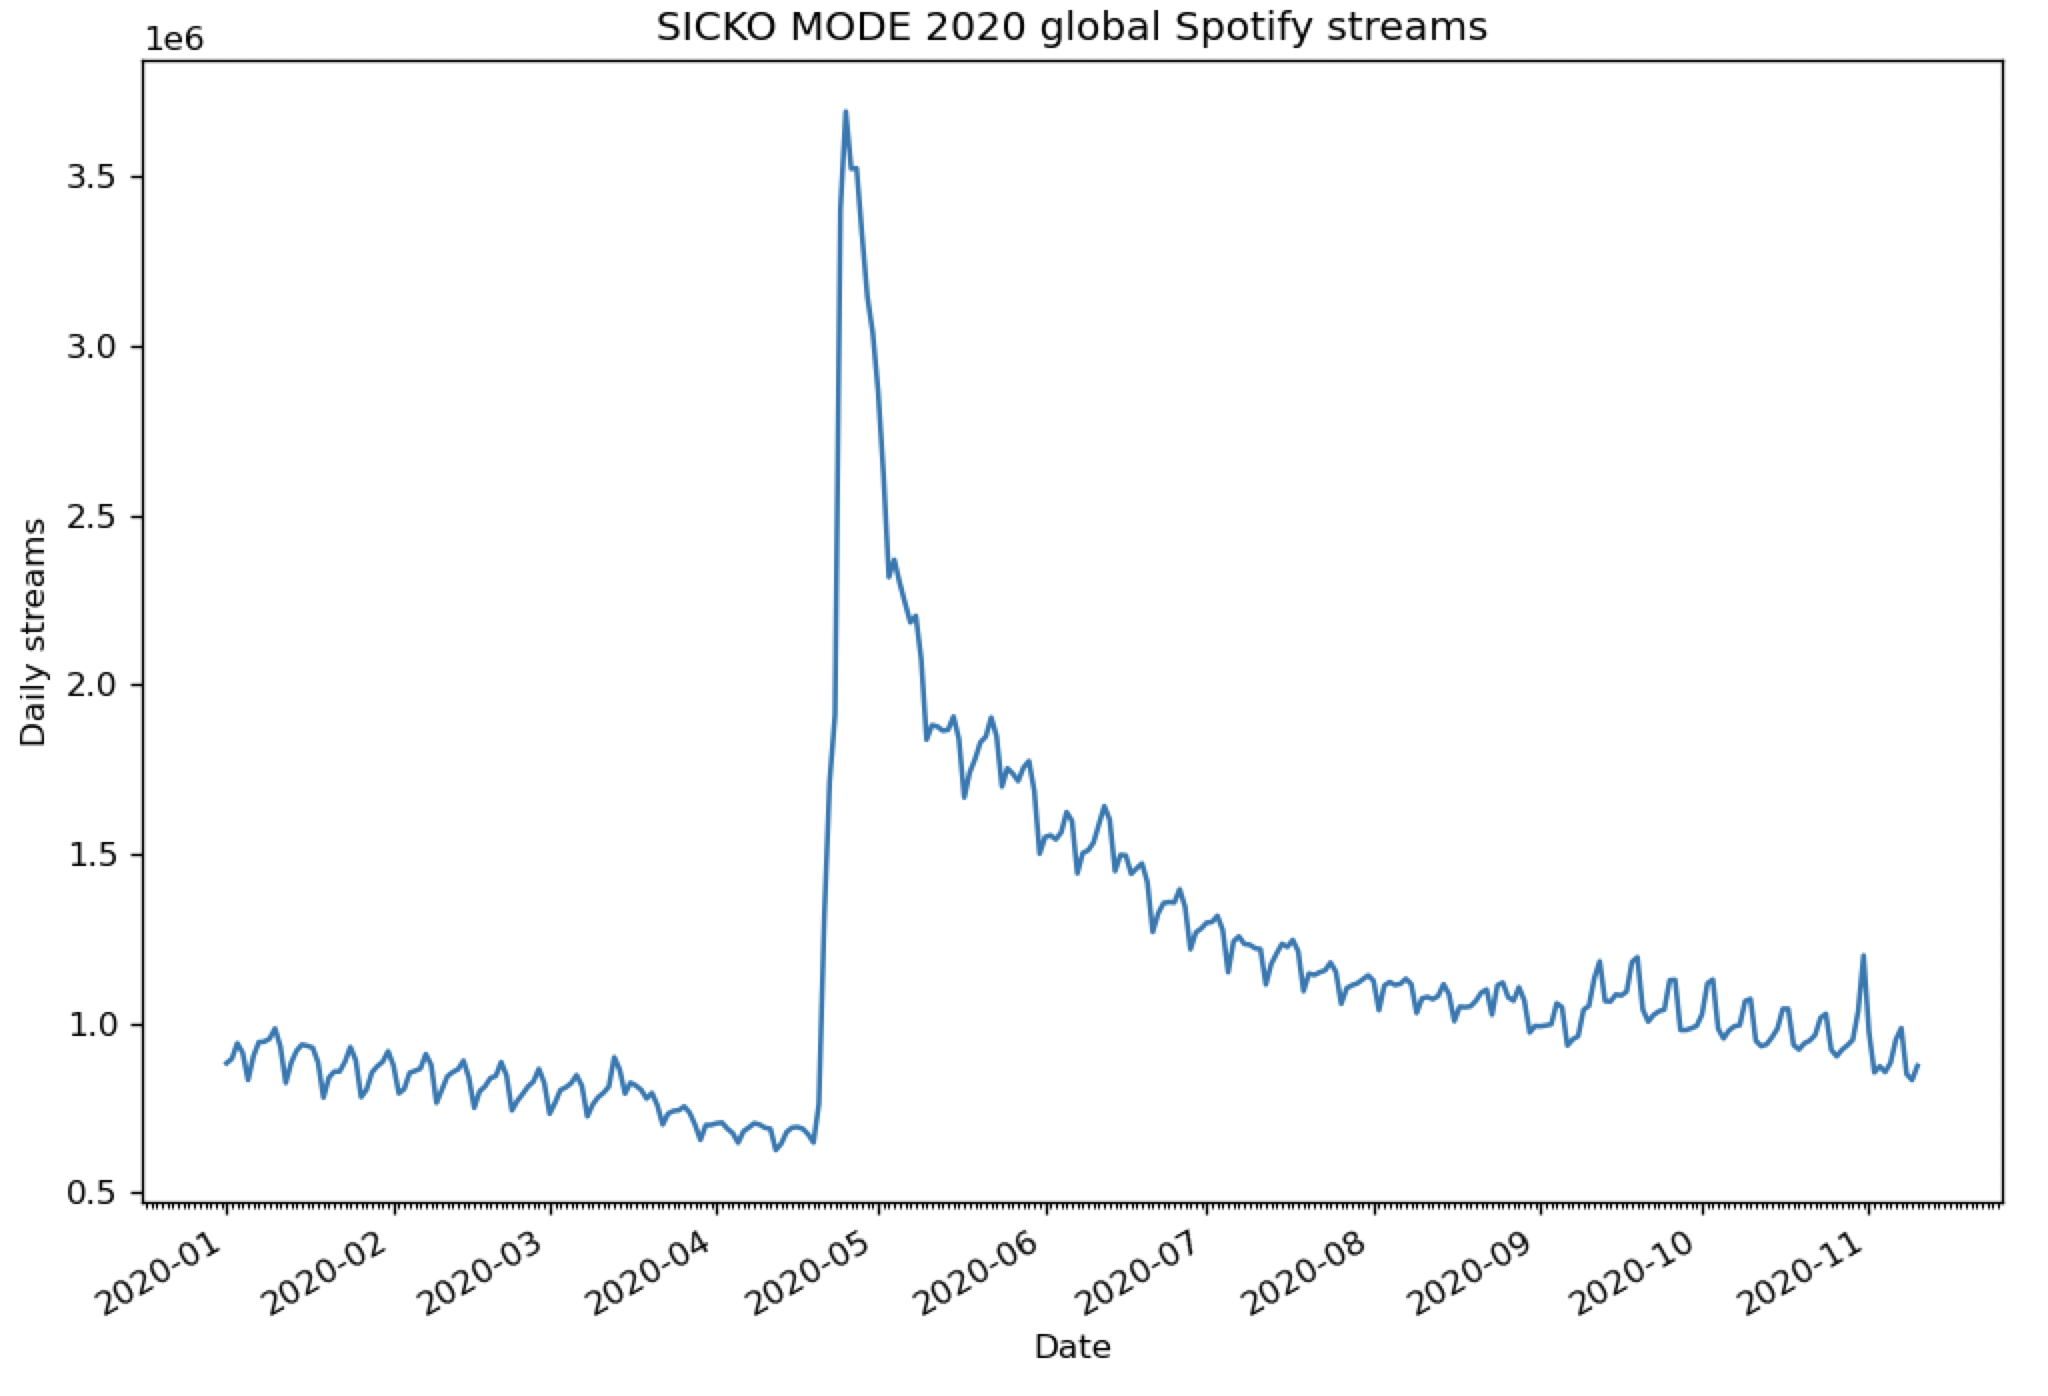

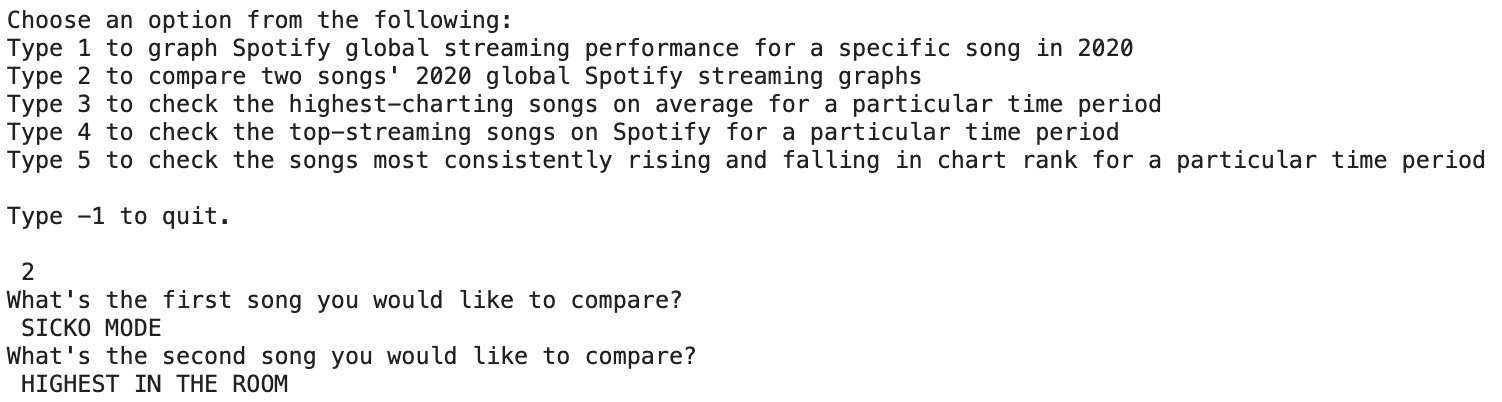
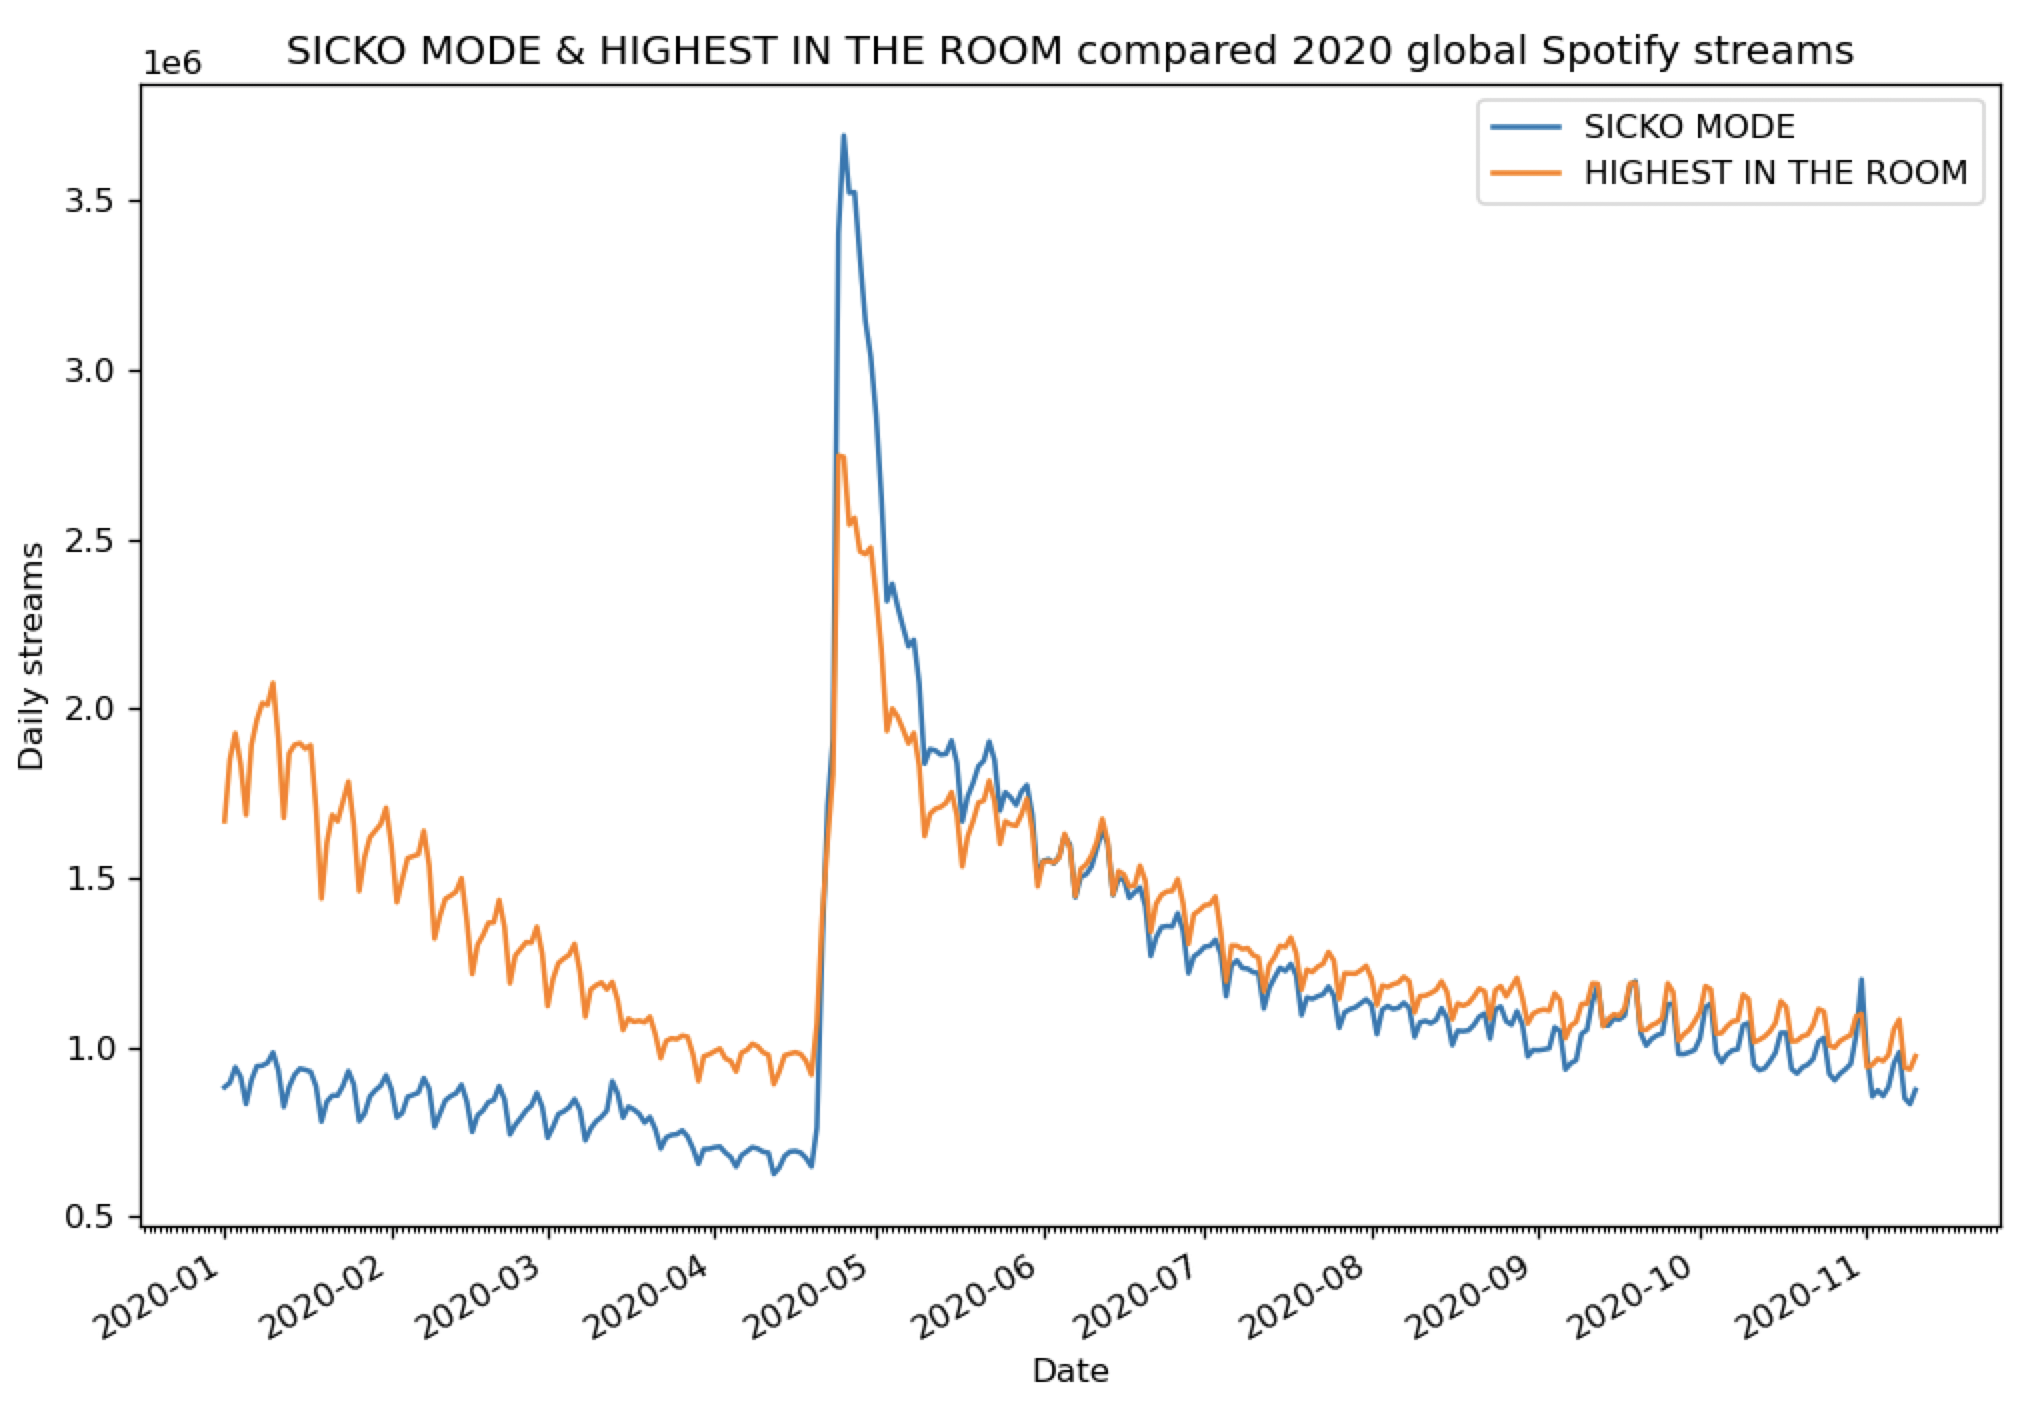

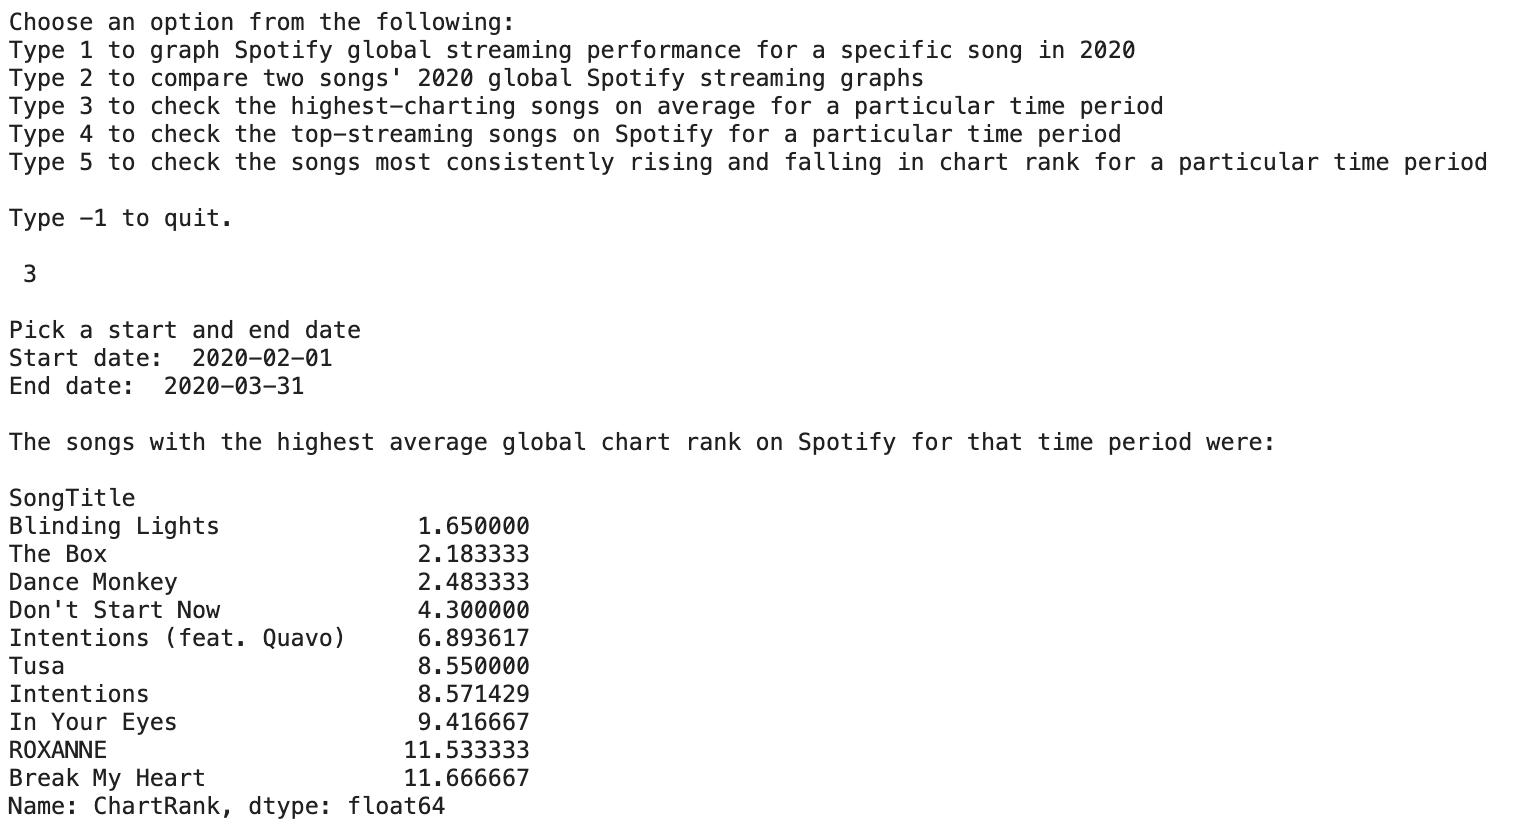

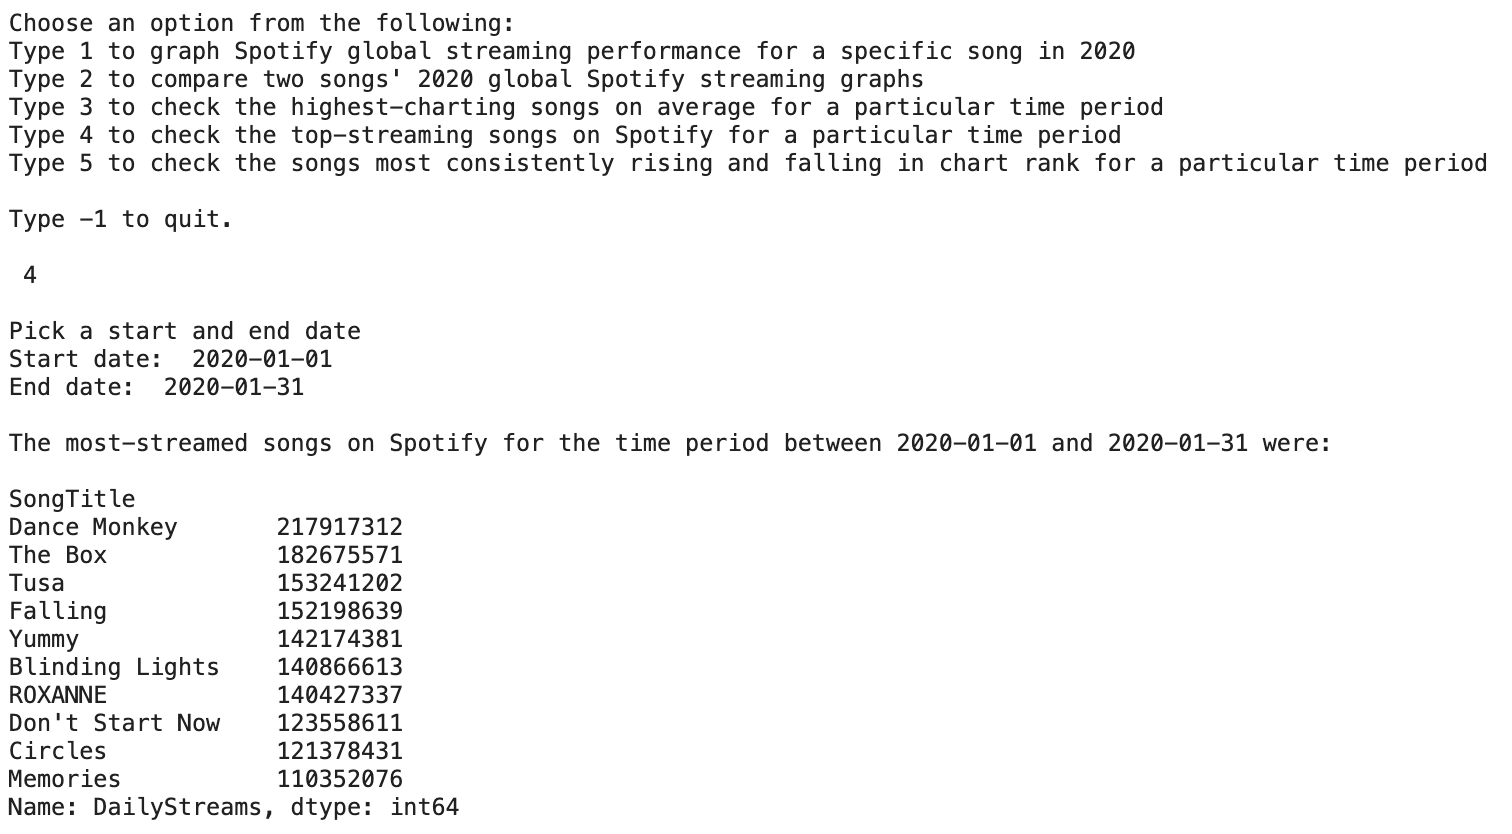

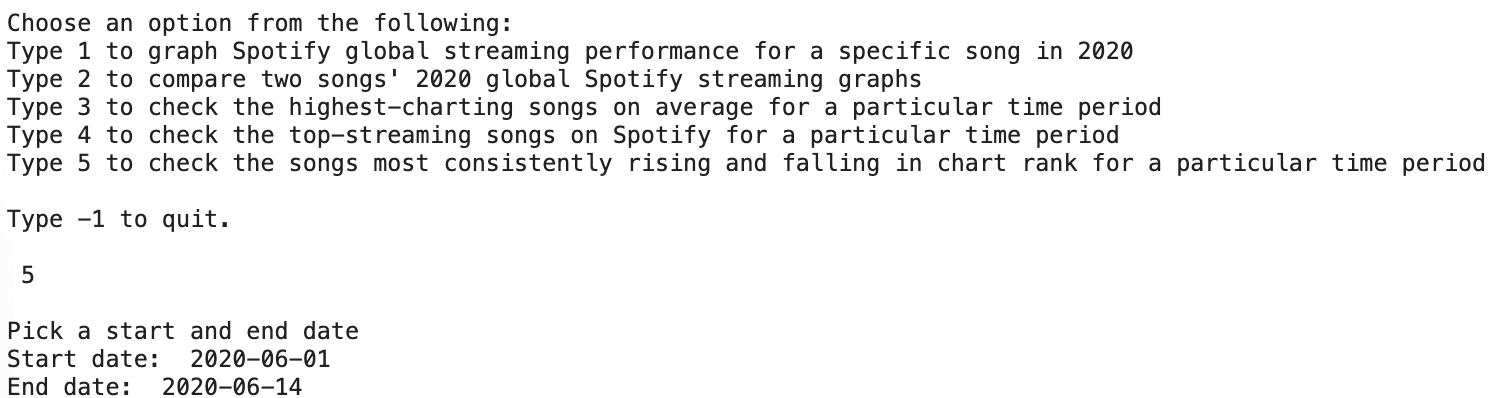
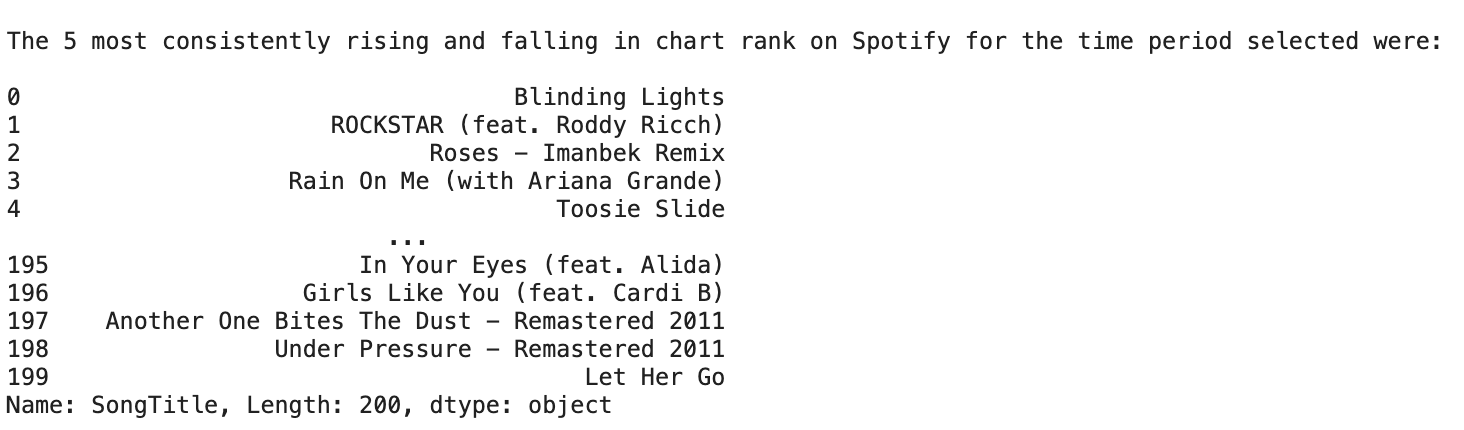

## Bootstrap Hypothesis Testing

One of the first scripts I wrote after scraping the Spotify.com data was aimed at doing one basic thing: summing plays from the global top 200 songs and displaying how the plays from top-200 songs change day-by-day across a year.

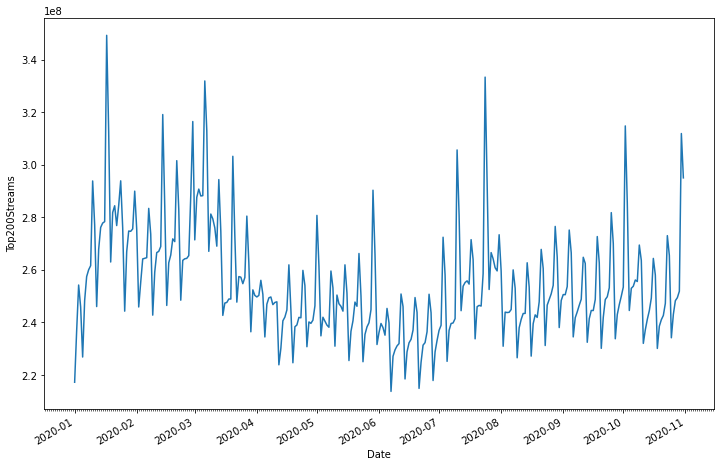

In [2]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import sys
from datetime import datetime, timedelta, date

days = mdates.DayLocator()  
months = mdates.MonthLocator() 

# Sets dates for Visualizer - change dates as is appropriate or desired
start_date = (pd.to_datetime('2020-01-01', format='%Y-%m-%d')).date()
end_date = (pd.to_datetime('2020-11-01', format='%Y-%m-%d')).date()
date_data = []

# Reads scraped Spotify.com chart data from master CSV, and creates new CSV for visualization and bootstrap experiment
for single_date in (start_date + timedelta(n) for n in range(int((end_date - start_date).days))):

    converted_date = (pd.to_datetime(single_date).date())
    daily200streams = 0
    day_of_week = converted_date.strftime('%A')
    with open ("MasterSpotifyData.csv", "r") as g:
        timestreamdata = csv.reader(g)
        for line in timestreamdata:
            if str(line[4]) == str(converted_date):
                daily200streams += int(line[2])
    with open ("SpotifyTop200Streams.csv", "a") as f:
        data_handler = csv.writer(f, delimiter=",")
        data_handler.writerow([converted_date, daily200streams, day_of_week])

# Visualizes scraped data
df = pd.read_csv('SpotifyTop200Streams.csv', names=['Date','Top200Streams','Day'])
df['Date'] = pd.to_datetime(df['Date'])
fig, ax = plt.subplots()
ax.plot(df.Date, df.Top200Streams)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
plt.rcParams['figure.figsize'] = [18, 12]
plt.xlabel("Date")
plt.ylabel("Top200Streams")
fig.autofmt_xdate()
plt.show()

I wasn't expecting to see anything, so I was surprised at what I saw. There _seemed_ to be a recurring pattern in the data that I wasn't expecting: a weekly pattern of streams rising for several days, and then falling back down much more quickly.

As someone who spent many years as a music engineer and producer before learning to code, I was actually expecting the opposite trend with this graph. Music is generally released on Fridays on streaming services, and is typically a day where music listeners excitedly consume big-name new releases. Thus, I was expecting the graph below to peak on Fridays - which it does - but then slowly descend until the next Friday. Instead, what appears to happen on the graph is that music streams peak on Friday, trend downward until Monday, but then slowly climb until Friday. 

I would have expected streams from Monday through Thursday to be close to identical in a given week, if not trending downward slightly due to growing disinterest of the last week's music. So, I wanted to test whether the apparent trend of top-200 music streaming increasing from Monday to Friday in a given week was a true trend or a figment of the data.

In [12]:
df.iloc[299:304]

,Date,Top200Streams,Day
299,2020-10-26,243004361,Monday
300,2020-10-27,248233045,Tuesday
301,2020-10-28,249376536,Wednesday
302,2020-10-29,251834604,Thursday
303,2020-10-30,311840868,Friday


The script below depends on a custom module `bootstrapstats` that I have placed statistical functions into.

For each week of 2020, it shuffles the summed total streams from Spotify's top 200 songs on Monday, Tuesday, Wednesday, and Thursday with replacement into comparable "bootstrap weeks". In other words, it takes the observed (true) streaming data from every week, and randomly shuffles the days' streams, so that Monday's streaming data becomes Thursday's, or Wednesday's becomes both Monday's and Tuesday's data. The mean of the real weeks' slopes of summed global streams (from Mon->Thurs) is compared with that of the bootstrap weeks. This process is repeated 100 times. The proportion of times the bootstrap weeks' mean streaming slope exceeds that of the real weeks is computed into a p value.

The observed mean stream slope from Monday through Thursday on a given week in 2020 was:
 1639450.6186045997


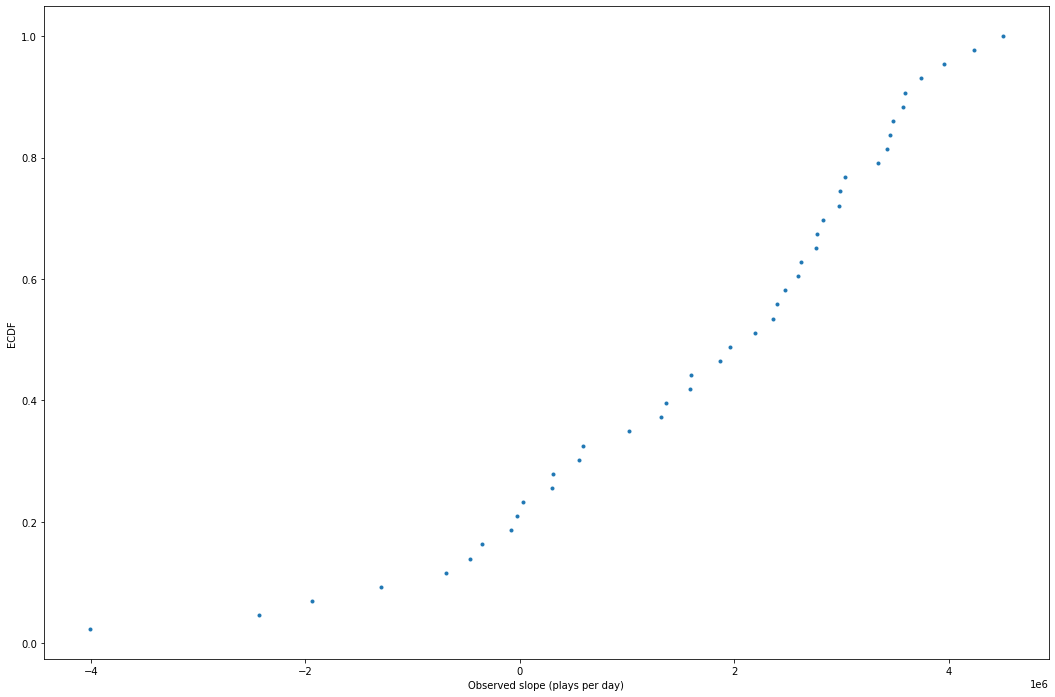

The bootstrap-simulated mean stream slope from Monday through Thursday on a given week in 2020 was:
 -32286.898883777143
p =  0.0


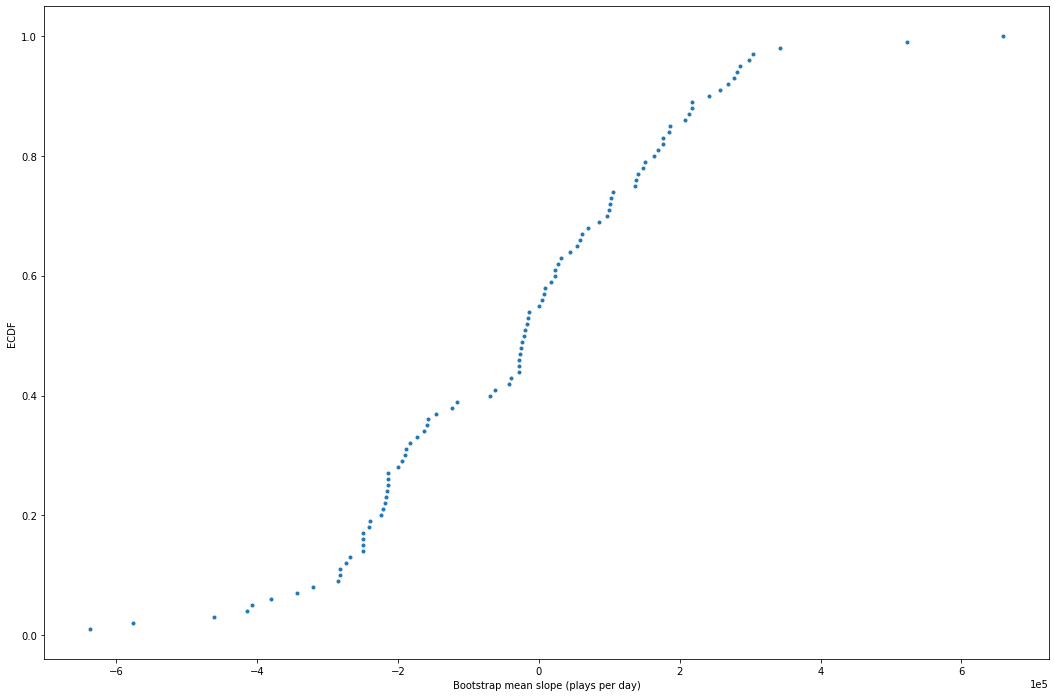

In [12]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import sys
from datetime import datetime, timedelta, date
from bootstrapstats import draw_bs_pairs_linreg, ecdf

df = pd.read_csv('SpotifyTop200Streams.csv', names=['Date','Top200Streams','Day_Of_Week'])
df['Date'] = pd.to_datetime(df['Date'])

# Sets default dates and make relevant date conversions
studystart = pd.to_datetime(date(2020, 1, 1))
studyend = pd.to_datetime(date(2020, 11, 5))
interdf = df.loc[df.Date <= studyend].copy()
weeksdf = interdf.loc[interdf.Date >= studystart].copy()
weeksdf['WeekNo'] = weeksdf.Date.dt.strftime('%W').copy()
weeksdf.WeekNo = weeksdf.WeekNo.astype('int64')

# Excludes days of week that are not part of experiment
weeksdf = weeksdf[weeksdf.Day_Of_Week != "Friday"]
weeksdf = weeksdf[weeksdf.Day_Of_Week != "Saturday"]
weeksdf = weeksdf[weeksdf.Day_Of_Week != "Sunday"]

# Creates arrays to hold regression coefficients for observed data
obs_slopes = np.empty(weeksdf['WeekNo'].max())
obs_intercepts = np.empty(weeksdf['WeekNo'].max())
x = [0, 1, 2, 3]

# Fits each Monday-Thursday week of observed streaming data into a linear function; slopes are parameter of interest
for i in range(weeksdf['WeekNo'].max()):
    y = [int(weeksdf.loc[(weeksdf['WeekNo'] == (i + 1)) & (weeksdf['Day_Of_Week'] == 'Monday')]['Top200Streams'].values), 
        int(weeksdf.loc[(weeksdf['WeekNo'] == (i + 1)) & (weeksdf['Day_Of_Week'] == 'Tuesday')]['Top200Streams'].values),
        int(weeksdf.loc[(weeksdf['WeekNo'] == (i + 1)) & (weeksdf['Day_Of_Week'] == 'Wednesday')]['Top200Streams'].values),
        int(weeksdf.loc[(weeksdf['WeekNo'] == (i + 1)) & (weeksdf['Day_Of_Week'] == 'Thursday')]['Top200Streams'].values)]
    a, b = np.polyfit(x, y, 1)
    obs_slopes[i] = a
    obs_intercepts[i] = b

# Calculates observed mean weekly streaming slope
obs_mean_slope = obs_slopes.mean()
print("The observed mean stream slope from Monday through Thursday on a given week in 2020 was:\n",obs_mean_slope)

# Creates ECDF showing each observed week's streaming slope
x_obsmean, y_obsmean = ecdf(obs_slopes)
_ = plt.plot(x_obsmean, y_obsmean, marker='.', linestyle='none')
_ = plt.xlabel("Observed slope (plays per day)")
_ = plt.ylabel("ECDF")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

# Creates empty array to hold 100 bootstrap mean weekly streaming slopes
bs_meanslope_reps = np.empty(100)

# Bootstrapping: resamples the streaming counts of each day in every week individually with replacement,
#  and computes mean streaming slope across all weeks. Repeats process 100 times.
for q in range(100):
    bs_slopes = np.empty(weeksdf['WeekNo'].max())
    bs_intercepts = np.empty(weeksdf['WeekNo'].max())
    for i in range(weeksdf['WeekNo'].max()):
        y_np = [int(weeksdf.loc[(weeksdf['WeekNo']==(i+1)) & (weeksdf['Day_Of_Week']=='Monday')]['Top200Streams'].values), 
            int(weeksdf.loc[(weeksdf['WeekNo']==(i+1)) & (weeksdf['Day_Of_Week']=='Tuesday')]['Top200Streams'].values),
            int(weeksdf.loc[(weeksdf['WeekNo']==(i+1)) & (weeksdf['Day_Of_Week']=='Wednesday')]['Top200Streams'].values),
            int(weeksdf.loc[(weeksdf['WeekNo']==(i+1)) & (weeksdf['Day_Of_Week']=='Thursday')]['Top200Streams'].values)]
        y = np.array(y_np, dtype=int)
        x_array = np.array(x, dtype=int)
        inds = np.arange(len(x_array))
        bs_inds = np.random.choice(inds, size=len(inds), replace=True)
        bs_x = x_array
        bs_y = np.array([y[bs_inds][0], y[bs_inds][1], y[bs_inds][2], y[bs_inds][3]])
        c, d = np.polyfit(bs_x, bs_y, 1)  
        bs_slopes[i] = c
        bs_intercepts[i] = d
        
    bs_meanslope_reps[q] = bs_slopes.mean()

# Prints mean of all 100 bootstrap weeks' mean streaming slopes;
#  p value represents how many times mean bootstrap weeks' streaming slope beat the observed weeks' streaming slope
print("The bootstrap-simulated mean stream slope from Monday through Thursday on a given week in 2020 was:\n",bs_meanslope_reps.mean())
p = np.sum(bs_meanslope_reps >= obs_mean_slope) / 100
print('p = ', p)
x_bs_meanslope, y_bs_meanslope = ecdf(bs_meanslope_reps)

# Creates ECDF for bootstrap weeks' mean streaming slopes
_ = plt.plot(x_bs_meanslope, y_bs_meanslope, marker='.', linestyle='none')
_ = plt.xlabel("Bootstrap mean slope (plays per day)")
_ = plt.ylabel("ECDF")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

### Conclusion

So, all 100 times 2020's streaming data is randomly shuffled, the average shuffled week's streaming trend isn't as upward climbing from Monday through Thursday as it is in the observed data. Therefore, this suggests that users truly do stream more every day from Monday through Thursday. In my 2019 research, the effect persisted with the same p-value when comparing Tuesday through Thursday as well. 

The ECDF figures above illustrate this result. The top ECDF captures the slope of top-200 stream counts from Monday through Thursday for each observed week in 2020. In contrast, the bottom ECDF captures the mean slope of stream counts from Monday through Thursday for a whole year of bootstrap weeks, which was computed 100 times. Not even the highest mean bootstrap stream slope - somewhere around 700,000 - exceeds the observed mean stream slope.

Why might this people stream more music from Monday through Thursday? Perhaps people become excited for Friday. Perhaps people are industrious in the beginning of the week, and tend to work less and listen more as the work week proceeds. Whatever the true reason, it's a neat observation, and I enjoyed examining it with this bootstrap experiment.